In [28]:
import os
from os.path import join, split
from glob import glob
import pandas as pd
import numpy as np
from rdkit import Chem
from mordred import descriptors, Calculator
from tqdm import tqdm_notebook
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprintAsBitVect

from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.model_selection import cross_val_predict, GridSearchCV, StratifiedKFold, permutation_test_score
from sklearn.metrics import make_scorer, r2_score, roc_auc_score, precision_score, classification_report, precision_recall_fscore_support
from sklearn import metrics
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

### Files paths 

In [29]:
ligands_fpath = join('ligands_curated.sdf')
cds_fpath = join('cyclodextrins_curated.sdf')

### Metrics definition 

In [30]:
def stats(y_train, y_pred):
    roc_auc = metrics.roc_auc_score(y_train, y_pred)
    confusion_matrix = metrics.confusion_matrix(y_train, y_pred>0.5)
    accuracy = metrics.accuracy_score(y_train, y_pred>0.5)
    Kappa = metrics.cohen_kappa_score(y_train, y_pred>0.5, weights='linear')
    # True and false values
    TN, FP, FN, TP = confusion_matrix.ravel()  
    # Sensitivity, hit rate, recall, or true positive rate
    SE = TP/(TP+FN)
    # Specificity or true negative rate
    SP = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Correct classification rate
    CCR = (SE + SP)/2
    d = dict({'Accuracy': accuracy,
         'AUC': roc_auc,
         'Kappa': Kappa,
         'CCR': CCR,
         'Sensitivity': SE,
         'PPV': PPV,
         'Specificity': SP,
         'NPV': NPV})
    return pd.DataFrame(d, columns=d.keys(), index=[0]).round(2)

In [31]:
gridParams = {
    'learning_rate': [0.15],
    'n_estimators': [1000],
    'num_leaves': [63], 
    'boosting_type' : ['dart'],
    'max_bin':[127], 
    'random_state' : [44],
    'colsample_bytree' : [0.6],
    'subsample' : [ 0.6],
    'reg_alpha' : [0],
    'reg_lambda' : [0],
    'n_jobs' : [8],
    'min_child_samples' : [15, 20, 25]
    }

#### Descriptors clean-up function 

In [32]:
def clean_up(descs):
    
    #remove every column with NaNs
    descs = descs[:, np.all(np.isfinite(descs), axis=0)]
    #remove varables with less than 5% variance
    descs = descs[:, ~(descs.std(axis=0)<0.05)]
    
    #Iteratively remove cross-correlated variables
    corrs = np.array([1])
    bar = tqdm_notebook()
    while np.any(corrs>0.95):
        corrs = np.corrcoef(descs.T)**2
        corrs[np.triu_indices_from(corrs)]=0
        idx1, idx2 = np.unravel_index(np.argmax(corrs), corrs.shape)
        descs = descs[:,~(np.arange(len(descs.T))==idx1)]
        bar.update(1)
    
    return descs

### Load data

#### Precalculated Dragon descriptors

try:
    
    dragon_descs_ligands = np.load(join('cache', 'dragon.npz'))['dragon_descs_ligands']
    dragon_descs_cds = np.load(join('cache', 'dragon.npz'))['dragon_descs_cds']
    print('Descriptors loaded from cache')
    
except Exception as e:
    
    print(e)
    
    dragon_descs_ligands = pd.read_csv(join('external_descriptors', 'ligands_dragon.txt'), sep='\t', na_values='na')
    del dragon_descs_ligands['NAME']
    del dragon_descs_ligands['No.']
    dragon_descs_ligands=dragon_descs_ligands.astype(float).values

    dragon_descs_ligands = clean_up(dragon_descs_ligands)

    dragon_descs_cds = pd.read_csv(join('external_descriptors', 'cyclodextrins_dragon.txt'), sep='\t', na_values='na')
    del dragon_descs_cds['NAME']
    del dragon_descs_cds['No.']
    dragon_descs_cds=dragon_descs_cds.astype(float).values

    dragon_descs_cds = clean_up(dragon_descs_cds)
        
    np.savez(join('cache', 'dragon.npz'), dragon_descs_ligands=dragon_descs_ligands, dragon_descs_cds=dragon_descs_cds)

#### Precalulated HIT QSAR descriptors - NOT AVAILABLE

#### Calculate Mordred

In [33]:
try:
    
    mordred_descs_ligands = np.load(join('cache', 'mordred.npz'))['mordred_descs_ligands']
    mordred_descs_cds = np.load(join('cache', 'mordred.npz'))['mordred_descs_cds']
    mordred_bank = np.load(join('cache', 'mordred.npz'))['mordred_bank']
    print('Descriptors loaded from cache')
    
except Exception as e:
    
    print(e)
    
    calc = Calculator(descriptors)
    reader = Chem.SDMolSupplier(ligands_fpath, removeHs=False)
    mordred_descs_ligands, exper_keys = [], []
    mordred_bank = {}
    
    for i, mol in tqdm_notebook(list(enumerate(reader))):
        if mol:
            mordred_descs_ligands.append(np.array(list(calc(mol))).astype(float))
            mordred_bank[Chem.inchi.MolToInchiKey(mol)]=mordred_descs_ligands[-1]
        else:
            print('Mol no. %d was not loaded'%i)     
    mordred_descs_ligands = np.array(mordred_descs_ligands).astype(float)  
    
    mordred_descs_ligands = clean_up(mordred_descs_ligands)

    reader = Chem.SDMolSupplier(cds_fpath, removeHs=False)
    mordred_descs_cds = []
    for mol in tqdm_notebook(reader):
        mordred_descs_cds.append(np.array(list(calc(mol))).astype(float))
        mordred_bank[Chem.inchi.MolToInchiKey(mol)]=mordred_descs_cds[-1]
    mordred_descs_cds = np.array(mordred_descs_cds).astype(float)
    
    mordred_descs_cds = clean_up(mordred_descs_cds)
    
    np.savez(join('cache', 'mordred.npz'), mordred_descs_ligands=mordred_descs_ligands, mordred_descs_cds=mordred_descs_cds,
            mordred_bank=mordred_bank)

Descriptors loaded from cache


#### Calculate Morgan

In [34]:
try:
    
    morgan_descs_ligands = np.load(join('cache', 'morgan.npz'))['morgan_descs_ligands']
    morgan_descs_cds = np.load(join('cache', 'morgan.npz'))['morgan_descs_cds']
    morgan_bank = np.load(join('cache', 'morgan.npz'))['morgan_bank']
    print('Descriptors loaded from cache')
    
except Exception as e:
    
    print(e)

    reader = Chem.SDMolSupplier(ligands_fpath, removeHs=False)
    morgan_descs_ligands = []
    morgan_bank = {}
    for i, mol in tqdm_notebook(list(enumerate(reader))):
        if mol:
            morgan_descs_ligands.append(np.array(GetMorganFingerprintAsBitVect(mol, 10, 2048, useChirality=True)))
            morgan_bank[Chem.inchi.MolToInchiKey(mol)]=morgan_descs_ligands[-1]
        else:
            print('Mol no. %d was not loaded'%i)
    morgan_descs_ligands = np.array(morgan_descs_ligands).astype(float)
    
    #morgan_descs_ligands = clean_up(morgan_descs_ligands)

    reader = Chem.SDMolSupplier(cds_fpath, removeHs=False)
    morgan_descs_cds = []
    for mol in tqdm_notebook(reader):
        morgan_descs_cds.append(np.array(GetMorganFingerprintAsBitVect(mol, 10, 256, useChirality=True)))
        morgan_bank[Chem.inchi.MolToInchiKey(mol)]=morgan_descs_cds[-1]
        
    morgan_descs_cds = np.array(morgan_descs_cds).astype(float)
    
    #morgan_descs_cds = clean_up(morgan_descs_cds)
    
    np.savez(join('cache', 'morgan.npz'), morgan_descs_ligands=morgan_descs_ligands, morgan_descs_cds=morgan_descs_cds, morgan_bank=morgan_bank)

Descriptors loaded from cache


#### Match calculated cyclodextrins descriptors with their names 

In [35]:
cyclodextrins={}
reader = Chem.SDMolSupplier(cds_fpath, removeHs=False)

descriptors = [mordred_descs_cds, morgan_descs_cds]

for i, (mordred, morgan, mol) in enumerate(zip(*descriptors, reader)):
    cyclodextrins[mol.GetProp('name')] = (mol, mordred, morgan)

In [36]:
data=[]
reader = Chem.SDMolSupplier(ligands_fpath, removeHs=False)

descriptors = [mordred_descs_ligands, morgan_descs_ligands]
exper_keys = [Chem.inchi.MolToInchiKey(m) for m in Chem.SDMolSupplier(ligands_fpath, removeHs=False) if m]

for i, (ikey, mol, mordred, morgan) in enumerate(zip(exper_keys, reader, *descriptors)):
    if mol:
        data.append([int(mol.GetProp('ID')), float(mol.GetProp('ph')), float(mol.GetProp('temperature')),
                     float(mol.GetProp('logk_range')), mol.GetProp('name'), mol.GetProp('Inchi_name'), mol, 
                     cyclodextrins[mol.GetProp('name')][0], 
                     mordred, cyclodextrins[mol.GetProp('name')][1], 
                     morgan, cyclodextrins[mol.GetProp('name')][2],
                    ikey])
    else:
        print('Mol no. %d was not loaded'%i)
data = pd.DataFrame(data, columns = ['id', 'ph', 'temperature', 'logk_range', 'cd_name', 'inchi_name', 'mol', 'cd_mol', 
                                     'mordred_ligand', 'mordred_cd', 'morgan_ligand', 'morgan_cd', 'key'])

### Add custom CDs descriptors

In [37]:
methylation = {'SBEBCD':2, 'RMBCD':1, 'HEBCD': 3, 'DMBCD' : 1, 'DBBCD':3, 'TMACD':1, 'TMBCD':1, 'TMGCD':1}
side_2_descs = []
for n in data.cd_name:
    if n in methylation.keys():
        side_2_descs.append(1)
    else:
        side_2_descs.append(0)
side_2_descs = np.array(side_2_descs)

n_glucosides = {'ACD':6, 'BCD':7, 'GCD':8}
CD_code =  {n:i for n,i in zip(data['cd_name'].unique(), range(len(data['cd_name'].unique())))}
encoded_cd = [np.array([n_glucosides[n[-3:]], CD_code[n]]) for n in data.cd_name]
data['side_2_descs'] = side_2_descs

In [38]:
data.to_pickle('CD_data.pkl')

## QSPR 

In [39]:
df = data.copy()

### Remove outliers

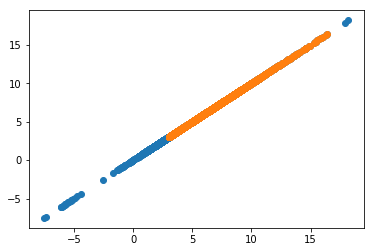

In [40]:
y_org = data.logk_range.values
plt.scatter(y_org, y_org)
mask = (y_org>3) & (y_org<17.5)
plt.scatter(y_org[mask], y_org[mask])

df = df.iloc[mask]

# Tests 

### Handle missing data

In [41]:
add_descs = np.concatenate([df['temperature'].values[:,None], df['ph'].values[:,None]], axis=1)
encoded_cd = [np.array([n_glucosides[n[-3:]], CD_code[n]]) for n in df.cd_name]

In [42]:
temp_fill = add_descs[:,0][add_descs[:,0]!=-1].mean()
add_descs[:,0][add_descs[:,0]==-1] = temp_fill
print('Missign temp filled with: %.2f C'%temp_fill)
ph_fill = add_descs[:,1][add_descs[:,1]!=-1].mean()
add_descs[:,1][add_descs[:,1]==-1] = ph_fill
print('Missign pH filled with: %.2f'%ph_fill)

Missign temp filled with: 25.78 C
Missign pH filled with: 7.15


Text(0.5,0,'Log Ks')

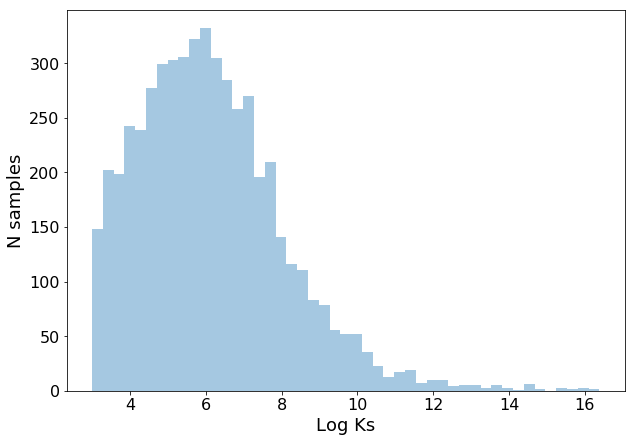

In [43]:
plt.figure(figsize=(10,7))
sns.distplot(df['logk_range'].values, kde=False)
plt.xticks(size=16)
plt.yticks(size=16)
plt.ylabel('N samples', size=18)
plt.xlabel('Log Ks', size=18)

In [44]:
screen_mol = Chem.SDMolSupplier(join('screening', 'CA.sdf'), removeHs=False)[0]
screen_desc = GetMorganFingerprintAsBitVect(screen_mol, 10, 2048, useChirality=True)

cd_names_order = []
screening = []
for cd_name in set(df.cd_name.values):
    
    CD_d = df[df.cd_name==cd_name].iloc[0].morgan_cd
    add = [25, 7]
    enc = np.array(encoded_cd)[df.cd_name.values==cd_name][0]
    screening.append(np.concatenate([screen_desc, CD_d, add, enc]))
    cd_names_order.append(cd_name)

In [45]:
from imblearn.ensemble import BalancedBaggingClassifier

In [46]:
np.log(200)

5.298317366548036

In [ ]:
descriptor_spaces = ['morgan']
screen_preds = {}

API_spaces = [np.array([np.array(r) for r in df['%s_ligand'%name]]).astype(float) for name in descriptor_spaces]
CD_spaces = [np.array([np.array(r) for r in df['%s_cd'%name]]).astype(float) for name in descriptor_spaces]
API_descs = API_spaces[0]
CD_descs = CD_spaces[0]

k = df['logk_range'].values

th = [0, 4, 4.5, 5]
results = []

for th_level in range(1,5):
    
    y = k    
    mask = (y >= (th[th_level-1]))
    y_classes = y[mask]
    y_classes = y_classes>=(th[th_level]*1.1)

    classes_labels=['<%.2f'%(th[th_level]), '>=%.2f'%(th[th_level])]
    plt.figure(figsize=(7,4))
    plt.title('Threshold level %d'%th_level)
    plt.bar(np.unique(y_classes), np.bincount(y_classes), tick_label=classes_labels)
    plt.show() 
        
    est=LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=0.6,
                      importance_type='split', learning_rate=0.15, max_bin=127,
                      max_depth=-1, min_child_samples=20, min_child_weight=0.001,
                       min_split_gain=0.0, n_estimators=50, n_jobs=8, num_leaves=63,
                       objective=None, random_state=44, reg_alpha=0, reg_lambda=0,
                       silent=True, subsample=0.6, subsample_for_bin=200000,
                       subsample_freq=0, device_type='gpu')
    est = BalancedBaggingClassifier(est, sampling_strategy='auto', replacement=False, random_state=44, n_estimators=20)
    X = np.concatenate([API_descs, CD_descs, add_descs, encoded_cd], axis=1)[mask]
    y_preds = []
    y_true = []
    
    skf = StratifiedKFold(n_splits=5)
    for train_index, test_index in skf.split(X, y_classes):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y_classes[train_index], y_classes[test_index]

        print('Balance before clustering: %.2f'%(np.mean(y_train)))
        mask = y_train
        X_train_cls = X_train[mask]
        clu = DBSCAN(0.015, metric='jaccard')
        labels = clu.fit_predict(X_train_cls[:,:2048+256])
        noise_mask = (labels<0)

        print('Noise ratio: %.2f'%(np.mean(noise_mask)))

        X_train_noise = X_train_cls[noise_mask]
        X_train_clust = pd.DataFrame(X_train_cls[~noise_mask]).groupby(labels[~noise_mask]).mean()
        X_train_pos = np.concatenate([X_train_clust.values, X_train_noise])
        X_train_neg = X_train[~mask]
        X_train = np.concatenate([X_train_pos, X_train_neg])
        y_train = np.concatenate([np.ones((len(X_train_pos),)), np.zeros((len(X_train_neg),))])>0
        print('Balance after clustering: %.2f'%(np.mean(y_train)))
        
        est.fit(X_train, y_train)
        y_preds.append(est.predict_proba(X_test)[:,1])
        y_true.append(y_test)
    y_preds = np.concatenate(y_preds)
    y_true = np.concatenate(y_true)
    
    df_stats = stats(y_true, y_preds)
    df_stats.index = [th[th_level]]
    
    results.append(df_stats)
    
    X_screen = np.array(screening)
    est.fit(X, y_classes)
    screen_preds[th_level] = est.predict_proba(X_screen)[:,1]
    
display(pd.concat(results))

In [31]:
display(pd.concat(results))

,Accuracy,AUC,Kappa,CCR,Sensitivity,PPV,Specificity,NPV
3.91,0.72,0.77,0.37,0.70,0.75,0.85,0.66,0.50
4.60,0.68,0.70,0.26,0.66,0.70,0.86,0.61,0.39
5.29,0.67,0.70,0.30,0.66,0.70,0.79,0.62,0.50


In [33]:
pd.concat([pd.DataFrame(index=cd_names_order, data=screen_preds[i]).loc[['HPACD', 'HPBCD', 'BCD', 'ACD', 'RMBCD']] for i in range(1,4)],axis=1)

,0,0,0
HPACD,0.888988,0.495996,0.580875
HPBCD,0.939669,0.586805,0.601130
BCD,0.953431,0.625524,0.670204
ACD,0.712280,0.413886,0.601579
RMBCD,0.945445,0.595767,0.647581


### Y-randomization test 

In [139]:
est.estimators_[0]

Pipeline(memory=None,
         steps=[('sampler',
                 RandomUnderSampler(random_state=1165046975, ratio=None,
                                    replacement=False, return_indices=False,
                                    sampling_strategy='auto')),
                ('classifier',
                 LGBMClassifier(boosting_type='dart', class_weight=None,
                                colsample_bytree=0.6, importance_type='split',
                                learning_rate=0.15, max_bin=127, max_depth=-1,
                                min_child_samples=20, min_child_weight=0.001,
                                min_split_gain=0.0, n_estimators=1000, n_jobs=8,
                                num_leaves=63, objective=None,
                                random_state=1217357931, reg_alpha=0,
                                reg_lambda=0, silent=True, subsample=0.6,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


True score =  0.82 
Y-randomization =  0.48 
p-value =  0.0476
True score =  0.68 
Y-randomization =  0.48 
p-value =  0.0476
True score =  0.76 
Y-randomization =  0.48 
p-value =  0.0476
True score =  0.7 
Y-randomization =  0.47 
p-value =  0.0476


,Accuracy,Kappa,CCR,Sensitivity,PPV,Specificity,NPV
5.756463,0.74,0.48,0.74,0.74,0.72,0.75,0.76
7.129728,0.64,0.29,0.64,0.63,0.65,0.66,0.64
8.355765,0.71,0.42,0.71,0.67,0.68,0.75,0.74
9.222199,0.66,0.31,0.66,0.69,0.69,0.62,0.63


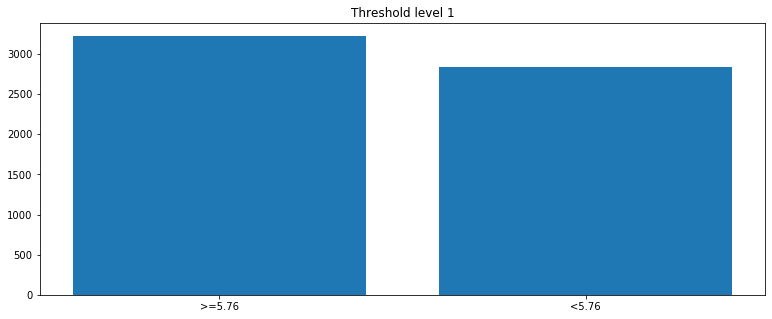

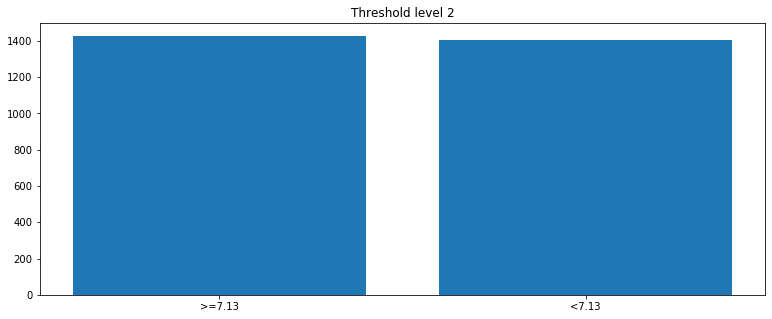

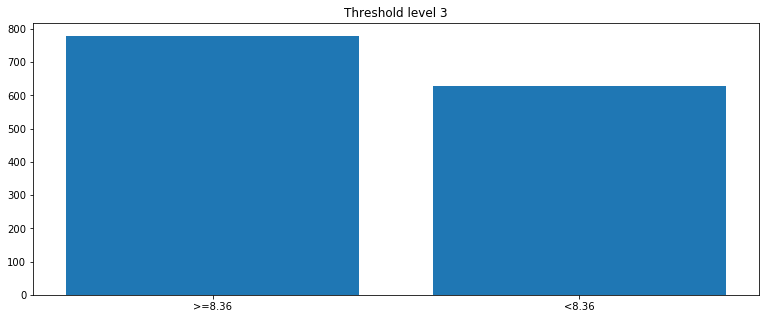

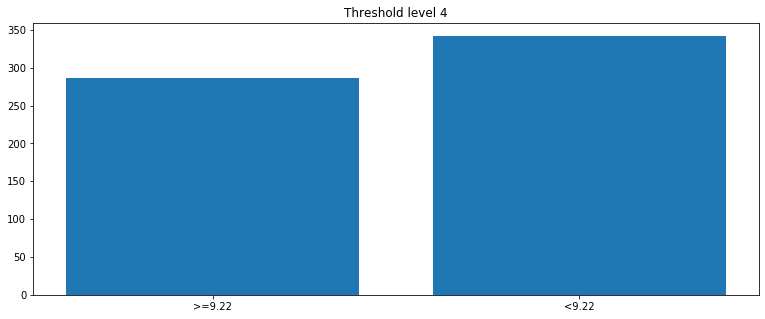

In [23]:
descriptor_spaces = ['mordred']
API_descs = [np.array([np.array(r) for r in df['%s_ligand'%name]]).astype(float) for name in descriptor_spaces][0]
CD_descs = [np.array([np.array(r) for r in df['%s_cd'%name]]).astype(float) for name in descriptor_spaces][0]

k = df['logk_range'].values

th = [np.log(t)+0.25*np.log(t) for t in [0, 100, 300, 800, 1600]]
results = []

for th_level in range(1,5):
    y = k
    
    mask = y>=th[th_level-1]
    y_classes = y[mask]
    y_classes = y_classes>=th[th_level]

    classes_labels=['>=%.2f'%(th[th_level]), '<%.2f'%(th[th_level])]
    plt.figure(figsize=(13,5))
    plt.title('Threshold level %d'%th_level)
    plt.bar(np.unique(y_classes), np.bincount(y_classes), tick_label=classes_labels)
    
    X = np.concatenate([API_descs, CD_descs, add_descs, encoded_cd], axis=1)[mask]
    
    est = LGBMClassifier()#GridSearchCV(LGBMClassifier(), param_grid=gridParams, n_jobs=1)
    y_preds = cross_val_predict(est, X, y_classes, method='predict_proba', cv=5)
    score, permutation_scores, pvalue = permutation_test_score(est, X, y_classes, cv=5, scoring='roc_auc',
                                                               n_permutations=20, n_jobs=1, verbose=0, random_state=44)
    print('True score = ', score.round(2), '\nY-randomization = ', np.mean(permutation_scores).round(2), '\np-value = ', pvalue.round(4))
    probs = y_preds
    pred_classes = np.argmax(probs, axis=1)
    
    y_true = LabelBinarizer().fit_transform(y_classes)
    y_predicted = LabelBinarizer().fit_transform(pred_classes)
    
    df_stats = stats(y_true, y_predicted)
    df_stats.index = [th[th_level]]
    
    results.append(df_stats)

display(pd.concat(results))

### One Model for all CDs 

In [ ]:
results_sep_reg = {}

env_descs = df[['ph', 'temperature']].values
API_descs_masked = API_descs
CD_descs_dragon = CD_descs
CD_descs_code = df['encoded_cd'].values
k_masked = k

for cd_desc_name, CD_descs_sel in zip([descriptors, 'code'], [CD_descs_dragon, CD_descs_code]):
    for env_descs in [[], env_descs]:

        if len(env_descs):
            remove_na_choices = [True, False]
        else:
            remove_na_choices = [False]

        for remove_na in remove_na_choices:

            if len(env_descs):
                env_added = True
            else:
                env_added = False

            reg = LGBMRegressor()

            y_pred, y, n_samples = model_test(API_descs_masked, k_masked, reg, CD_descs_sel, env_descs=env_descs, remove_na=remove_na)

            if np.any(np.array(y_pred)==None):
                continue

            press = np.sum((y_pred-y)**2)
            tss=np.sum((y-y.mean())**2)

            if remove_na:
                remove_na='Removed'
            else:
                remove_na='Preserved'

            if env_added:
                env_added='Added'
            else:
                env_added='Not added'

            results_sep_reg[(cd_desc_name, remove_na, env_added)] = (1-(press/tss), n_samples)
index = pd.MultiIndex.from_tuples(list(results_sep_reg.keys()), names=['CD descriptors', 'Missing data', 'Exp. conditions'])
results_df = pd.DataFrame(index=index, data=list(results_sep_reg.values()), columns=['Q2', 'N samples'])